<a href="https://colab.research.google.com/github/rselent/DS-Unit-2-Sprint-2-Kaggle-Challenge/blob/master/module4/2_2_4_assignment_kaggle_challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split

def dangleWrangle( x):
    x = x.copy()

    x['latitude'] = x['latitude'].replace( -2e-08, 0)
    zerodCols = ['latitude', 'longitude', 
                 'construction_year', 
                 'gps_height','population']
    for cols in zerodCols:
        x[cols] = x[cols].replace( 0, np.nan)
        x[cols + '_MISSING'] = x[cols].isnull()
    
    x['date_recorded'] = pd.to_datetime( x['date_recorded'], 
                                        infer_datetime_format= True)
    x['year_recorded'] = x['date_recorded'].dt.year
    x['month_recorded'] = x['date_recorded'].dt.month
    x['day_recorded'] = x['date_recorded'].dt.day

    ## moved date stratification up so df.drop only needs to be called once

    x = x.drop( columns= ['quantity_group', 'payment_type',     ## duplicates
                          'recorded_by', 'id',                  ## unusable
                          'date_recorded'])                     ## superfluous

    x['age'] = ( x['year_recorded'] - x['construction_year'] )
    x['years_MISSING'] = x['age'].isnull()

    return x

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

target = 'status_group'
train, validate = train_test_split( train, test_size= .5,
                                    stratify= train['status_group'],
                                    random_state= 16)

train = dangleWrangle( train)               ## Defining vars
validate = dangleWrangle( validate)
test = dangleWrangle( test)

xTrain = train.drop( columns= target)
yTrain = train[ target]
xValidate = validate.drop( columns= target)
yValidate = validate[ target]
xTest = test

popeline = make_pipeline(                   ## Nanananananananana, Popeline!
    ce.OrdinalEncoder(),
    SimpleImputer( strategy= 'mean'),
    RandomForestClassifier( n_estimators= 160, random_state= 16, n_jobs= -1)
)

popeline.fit( xTrain, yTrain)
yPred = popeline.predict( xValidate)
print( 'Validation accuracy: {:.5f}%'.format( 
        accuracy_score( yValidate, yPred) *100) )

Validation accuracy: 79.87542%


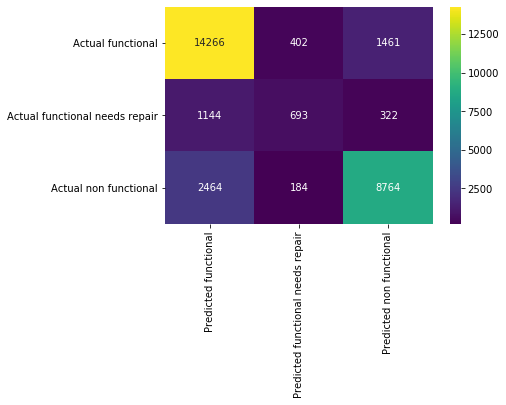

In [19]:
def confuMatrixPlot( yTrue, yPred):
    labeled = unique_labels( yTrue)
#    columned = ['Predicted {}'.format( labeled, for label in labeled)]     ## Oops. My way didn't work lol
#    indexed = ['Actual {}'.format( labeled, for label in labeled)]
    columned = [f'Predicted {label}' for label in labeled]
    indexed = [f'Actual {label}' for label in labeled]
    tabled = pd.DataFrame( confusion_matrix( yTrue, yPred),
                           columns= columned, index = indexed)
    return sns.heatmap( tabled, annot= True, fmt= 'd', cmap= 'viridis')

confuMatrixPlot( yValidate, yPred);

In [20]:
print( classification_report( yValidate, yPred) )

                         precision    recall  f1-score   support

             functional       0.80      0.88      0.84     16129
functional needs repair       0.54      0.32      0.40      2159
         non functional       0.83      0.77      0.80     11412

               accuracy                           0.80     29700
              macro avg       0.72      0.66      0.68     29700
           weighted avg       0.79      0.80      0.79     29700



In [0]:
yPred = popeline.predict( xTest)        ## For export

In [0]:
from google.colab import files

mySub = sample_submission.copy()
mySub[ 'status_group'] = yPred
mySub.to_csv( 'dsx-2-2-4-kaggle-rselent.csv', index= False)